In [111]:
import pandas as pd
import numpy as np

In [112]:
users_df = pd.read_csv("data/Users.csv")
postHistory_df = pd.read_csv("data/PostHistory.csv", low_memory=False)
badges_df = pd.read_csv("data/Badges.csv")

# clean users_df
users_df.drop(["Location", "Views", "WebsiteUrl", "EmailHash", "AboutMe", "ProfileImageUrl"], inplace=True, axis=1)

post_enums = {
    "Question": 1,
    "Answer": 2
}

postHistory_df.drop(postHistory_df[postHistory_df["OwnerUserId"] == "OwnerUserId"].index, inplace=True)
postHistory_df = postHistory_df.replace("NaN", np.nan)

for col in ["Score", "Id", "OwnerUserId", "PostTypeId"]:
    postHistory_df[col] = postHistory_df[col].astype(int)

# num posts
numPosts_df = postHistory_df.groupby("OwnerUserId").size()

# add in numPosts to each user
for id, numPosts in numPosts_df.items():

    # grouping to find more information about a user's activity
    user_posts = postHistory_df[postHistory_df["OwnerUserId"] == id]
    type_of_posts = user_posts.groupby("PostTypeId")
    num_posts = type_of_posts["Id"].count()
    avg_posts = type_of_posts["Score"].mean()

    # count number or questions and answers that a user has posted
    user_questions = num_posts.loc[post_enums["Question"]] if post_enums["Question"] in num_posts.index else 0
    user_answers = num_posts.loc[post_enums["Answer"]] if post_enums["Answer"] in num_posts.index else 0

    # calculate score for all user questions
    # NaN is used if user hasn't posted a question or answer
    avg_question_score = avg_posts.loc[post_enums["Question"]] if post_enums["Question"] in avg_posts.index else np.nan
    avg_answer_score = avg_posts.loc[post_enums["Answer"]] if post_enums["Answer"] in avg_posts.index else np.nan

    # add information about current user to users_df
    users_df.loc[users_df["Id"] == id, "NumPosts"] = numPosts
    users_df.loc[users_df["Id"] == id, "NumQuestions"] = user_questions
    users_df.loc[users_df["Id"] == id, "NumAnswers"] = user_answers
    users_df.loc[users_df["Id"] == id, "AvgQuestionScore"] = avg_question_score
    users_df.loc[users_df["Id"] == id, "AvgAnswerScore"] = avg_answer_score


In [113]:

postHistory_df.head(10)


,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,...,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense
0,1180,1,1232,NaN,1217852527910,NaN,25,5863,<p>I am looking to allow users to control of s...,281,...,1429309651760,1514439657633,How to make subdomain user accounts in a webapp,<web-applications><dns><subdomain><account>,4,0,0,NaN,NaN,CC BY-SA 3.0
1,15734,1,775195,NaN,1219122112183,NaN,15,14514,<p>I know that there is no official API for Go...,1890,...,1465316455660,1465316455660,Google Analytics Access with C#,<c#><google-analytics><google-analytics-api>,9,0,0,NaN,NaN,CC BY-SA 3.0
2,16757,2,NaN,8472,1219172915830,NaN,2,NaN,<p>My solution was to put the form on a separa...,744,...,1271694057780,1271694057780,NaN,NaN,NaN,0,NaN,NaN,1219172915830,CC BY-SA 2.5
3,16926,1,330236,NaN,1219178987967,NaN,20,2361,"<p>My HTML is all marked up, ready to make it ...",744,...,NaN,1618922769247,Tool for generating CSS skeleton?,<css><markup>,9,0,0,NaN,NaN,CC BY-SA 2.5
4,20321,1,NaN,NaN,1219334003020,NaN,9,1781,<p>I am developing a website that will manage ...,744,...,1251976244200,1272296554707,One database or many?,<performance><database-design><multi-tenant><m...,11,0,0,NaN,NaN,CC BY-SA 2.5
5,22699,2,NaN,7252,1219419976663,NaN,20,NaN,"<p>For myself, I have started insisting that e...",2509,...,1219427421733,1219427421733,NaN,NaN,NaN,2,NaN,NaN,NaN,CC BY-SA 2.5
6,22718,2,NaN,1669,1219420636420,NaN,5,NaN,"<p>I liked the <A HREF=""http://compilers.iecc....",2509,...,1220331161310,1220331161310,NaN,NaN,NaN,0,NaN,NaN,1222853426387,CC BY-SA 2.5
7,23017,2,NaN,1496,1219427270570,NaN,1,NaN,<p>I get all my unixish/GNU support using <A h...,2509,...,NaN,1219427270570,NaN,NaN,NaN,0,NaN,NaN,NaN,CC BY-SA 2.5
8,23052,2,NaN,23031,1219428202950,NaN,0,NaN,<p>I've only recently added unit testing to my...,2509,...,NaN,1219428202950,NaN,NaN,NaN,0,NaN,NaN,NaN,CC BY-SA 2.5
9,24259,2,NaN,3260,1219501703130,NaN,6,NaN,<p>This problem has been studied in some detai...,2509,...,1224175948750,1224175948750,NaN,NaN,NaN,0,NaN,NaN,NaN,CC BY-SA 2.5


In [114]:
reps = 0
for user in users_df.iterrows():
    reps += user[1]['Reputation']

avg_sample_rep = reps/users_df.shape[0]    

print(f"Average Sample Reputation: {round(avg_sample_rep, 2)}")

Average Sample Reputation: 319.85


In [115]:
len(users_df.index)

users_df[users_df["Reputation"] == 234218]

,Id,Reputation,CreationDate,DisplayName,LastAccessDate,UpVotes,DownVotes,AccountId,NumPosts,NumQuestions,NumAnswers,AvgQuestionScore,AvgAnswerScore
448,12870,234218,1221580948227,Oli,1682594779717,997,158,7412,827.0,212.0,615.0,80.990566,9.611382


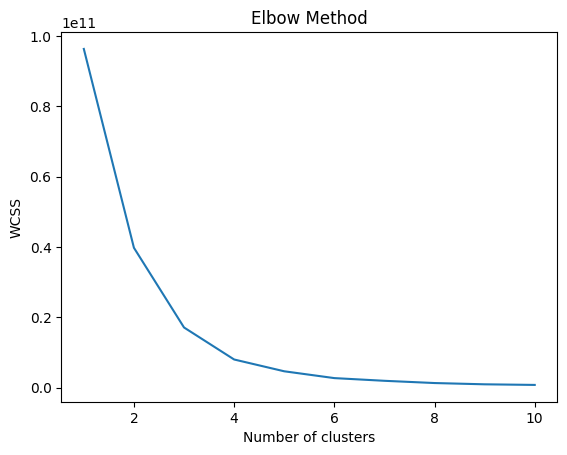

In [116]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

X = users_df[["Reputation", "NumPosts"]].values

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/home/foshes/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


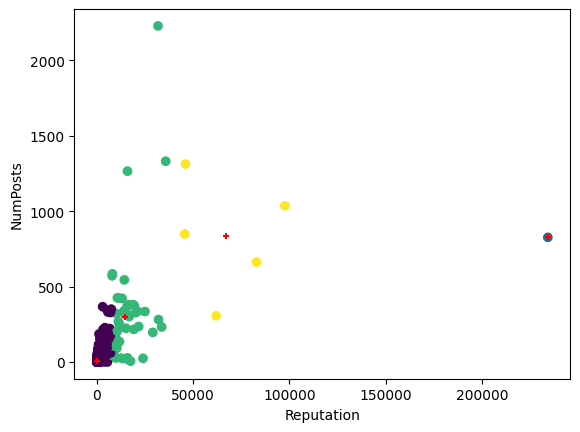

,Reputation,NumPosts,NumQuestions,NumAnswers,AvgQuestionScore,AvgAnswerScore,AvgUpVotesGiven,AvgDownVotesGiven
0,169.284756,6.772173,3.413936,3.351639,12.539251,21.386136,23.072811,2.686389
2,14759.740741,296.203704,59.944444,235.962963,217.588626,116.208506,1023.592593,95.222222
3,66822.600000,833.600000,37.400000,791.400000,103.685113,100.813167,3108.800000,990.000000
1,234218.000000,827.000000,212.000000,615.000000,809.905660,96.113821,997.000000,158.000000


In [117]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# k-means with reputation and numposts
data = users_df[['Reputation', 'NumPosts']].values

kmeans = KMeans(n_clusters=4)
kmeans.fit(data)

labels = kmeans.labels_
users_df['Cluster'] = labels

labels = kmeans.labels_
centers = kmeans.cluster_centers_

# scatter plot dis bih
plt.scatter(data[:, 0], data[:, 1], c=labels)

# plot center of each group
plt.scatter(centers[:, 0], centers[:, 1], marker='+', s=25, color='red')

plt.xlabel('Reputation')
plt.ylabel('NumPosts')
plt.show()


users_df.head(10)

analysis_df = pd.DataFrame(columns=["Reputation", "NumPosts"])

for label in set(labels):
    cluster = users_df[users_df['Cluster'] == label]
    new_row = pd.DataFrame([
        {
            'Reputation': cluster["Reputation"].mean(),
            'NumPosts': cluster["NumPosts"].mean(),
            'NumQuestions': cluster["NumQuestions"].mean(),
            'NumAnswers': cluster["NumAnswers"].mean(),
            'AvgQuestionScore': cluster["AvgQuestionScore"].mean() * 10, # multiply by 10 because that's how much rep 1 score point is worth (https://stackoverflow.help/en/articles/4396982-reputation)
            'AvgAnswerScore': cluster["AvgAnswerScore"].mean() * 10,
            'AvgUpVotesGiven': cluster["UpVotes"].mean(),
            'AvgDownVotesGiven': cluster["DownVotes"].mean()
        }
    ])

    analysis_df = pd.concat([analysis_df, new_row], ignore_index=True)

analysis_df.sort_values("Reputation", ascending=True).head(20)
